In [1]:
import numpy as np
import sys
sys.path.append('/Users/ariel/Documents/GitHub/pypulseq')
import pypulseq as pp

sys.path.append("utils/")
from trap_waveforms import *

sys.path.append("utils/gropt/python")
import gropt
from helper_utils import *

from matplotlib import pyplot as plt
import numpy as np
from numpy import arctan2, sqrt
import numexpr as ne

import pandas as pd
import seaborn as sns

In [2]:
input_params ={'mode': 'diff_bval', 
    'T_90': 2.02, 
    'T_180': 3.12, 
    'gmax': 100, 
    'smax': 100, 
    'dt': 1e-05, 
    'T_readout': 11.09,
    'b': 350, 
    'MMT': 2, 
    'pns_thresh': 0.8}


input_params['pns_thresh'] = 0.8
pns_thresh = 0.8
lim = 0.005

G,Time,echoT,b,pns,_,_,_ = calc_trap(input_params.copy(),lim,pns_thresh)
print('Traditional TE: {:.2f} ms, Computed B-val: {:.2f}, PNS: {:.2f}'.format(echoT,b,np.nanmax(pns))) 


gropt_params = input_params.copy()
input_params['TE'] = echoT
gropt_params['dt'] = 8e-5
gropt_params['smax'] = 200
gropt_params['gmax'] = 200

target_b = b
start_TE = echoT

#gropt_params, G_gropt, te_track, b_track =calc_grop_hybrid(gropt_params.copy(), input_params['b'], start_TE,  0.001,iterations=25,)
G_gropt, TE =  get_min_TE(gropt_params,verbose = True, bval =target_b)

print(gropt_params)
gropt_b = get_bval(G_gropt, gropt_params)
print('Gropt TE: {:.5f} ms, Gropt Bval: {:.2f}'.format(gropt_params['TE'],gropt_b, )) 
pns_gropt= np.abs(get_stim(G_gropt, gropt_params['dt'])) 

name = 'Waveform_b'+str(input_params['b']) + '_Res2.5_PNS' +\
    str(input_params['pns_thresh']) + '_MMT' + str(input_params['MMT'])

#plot_waveforms(input_params,gropt_params, G_gropt, Time, G, pns, pns_gropt,name)
print('Traditional TE: {:.2f} ms,Gropt TE: {:.5f} ms '.format(echoT,gropt_params['TE']))
print('Difference:', np.round((echoT- gropt_params['TE']),2), np.round(abs(echoT- gropt_params['TE'])/echoT*100,2))



grad_TRAP_m0 = G
grad_GrOpt_m0 = G_gropt

TE_TRAP_m0 = echoT
TE_GrOpt_m0 = gropt_params['TE']

KeyboardInterrupt: 

In [9]:
sns.set(font_scale=2.5) 

/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_63570/2624634203.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[ii,jj].legend(loc='lower right')


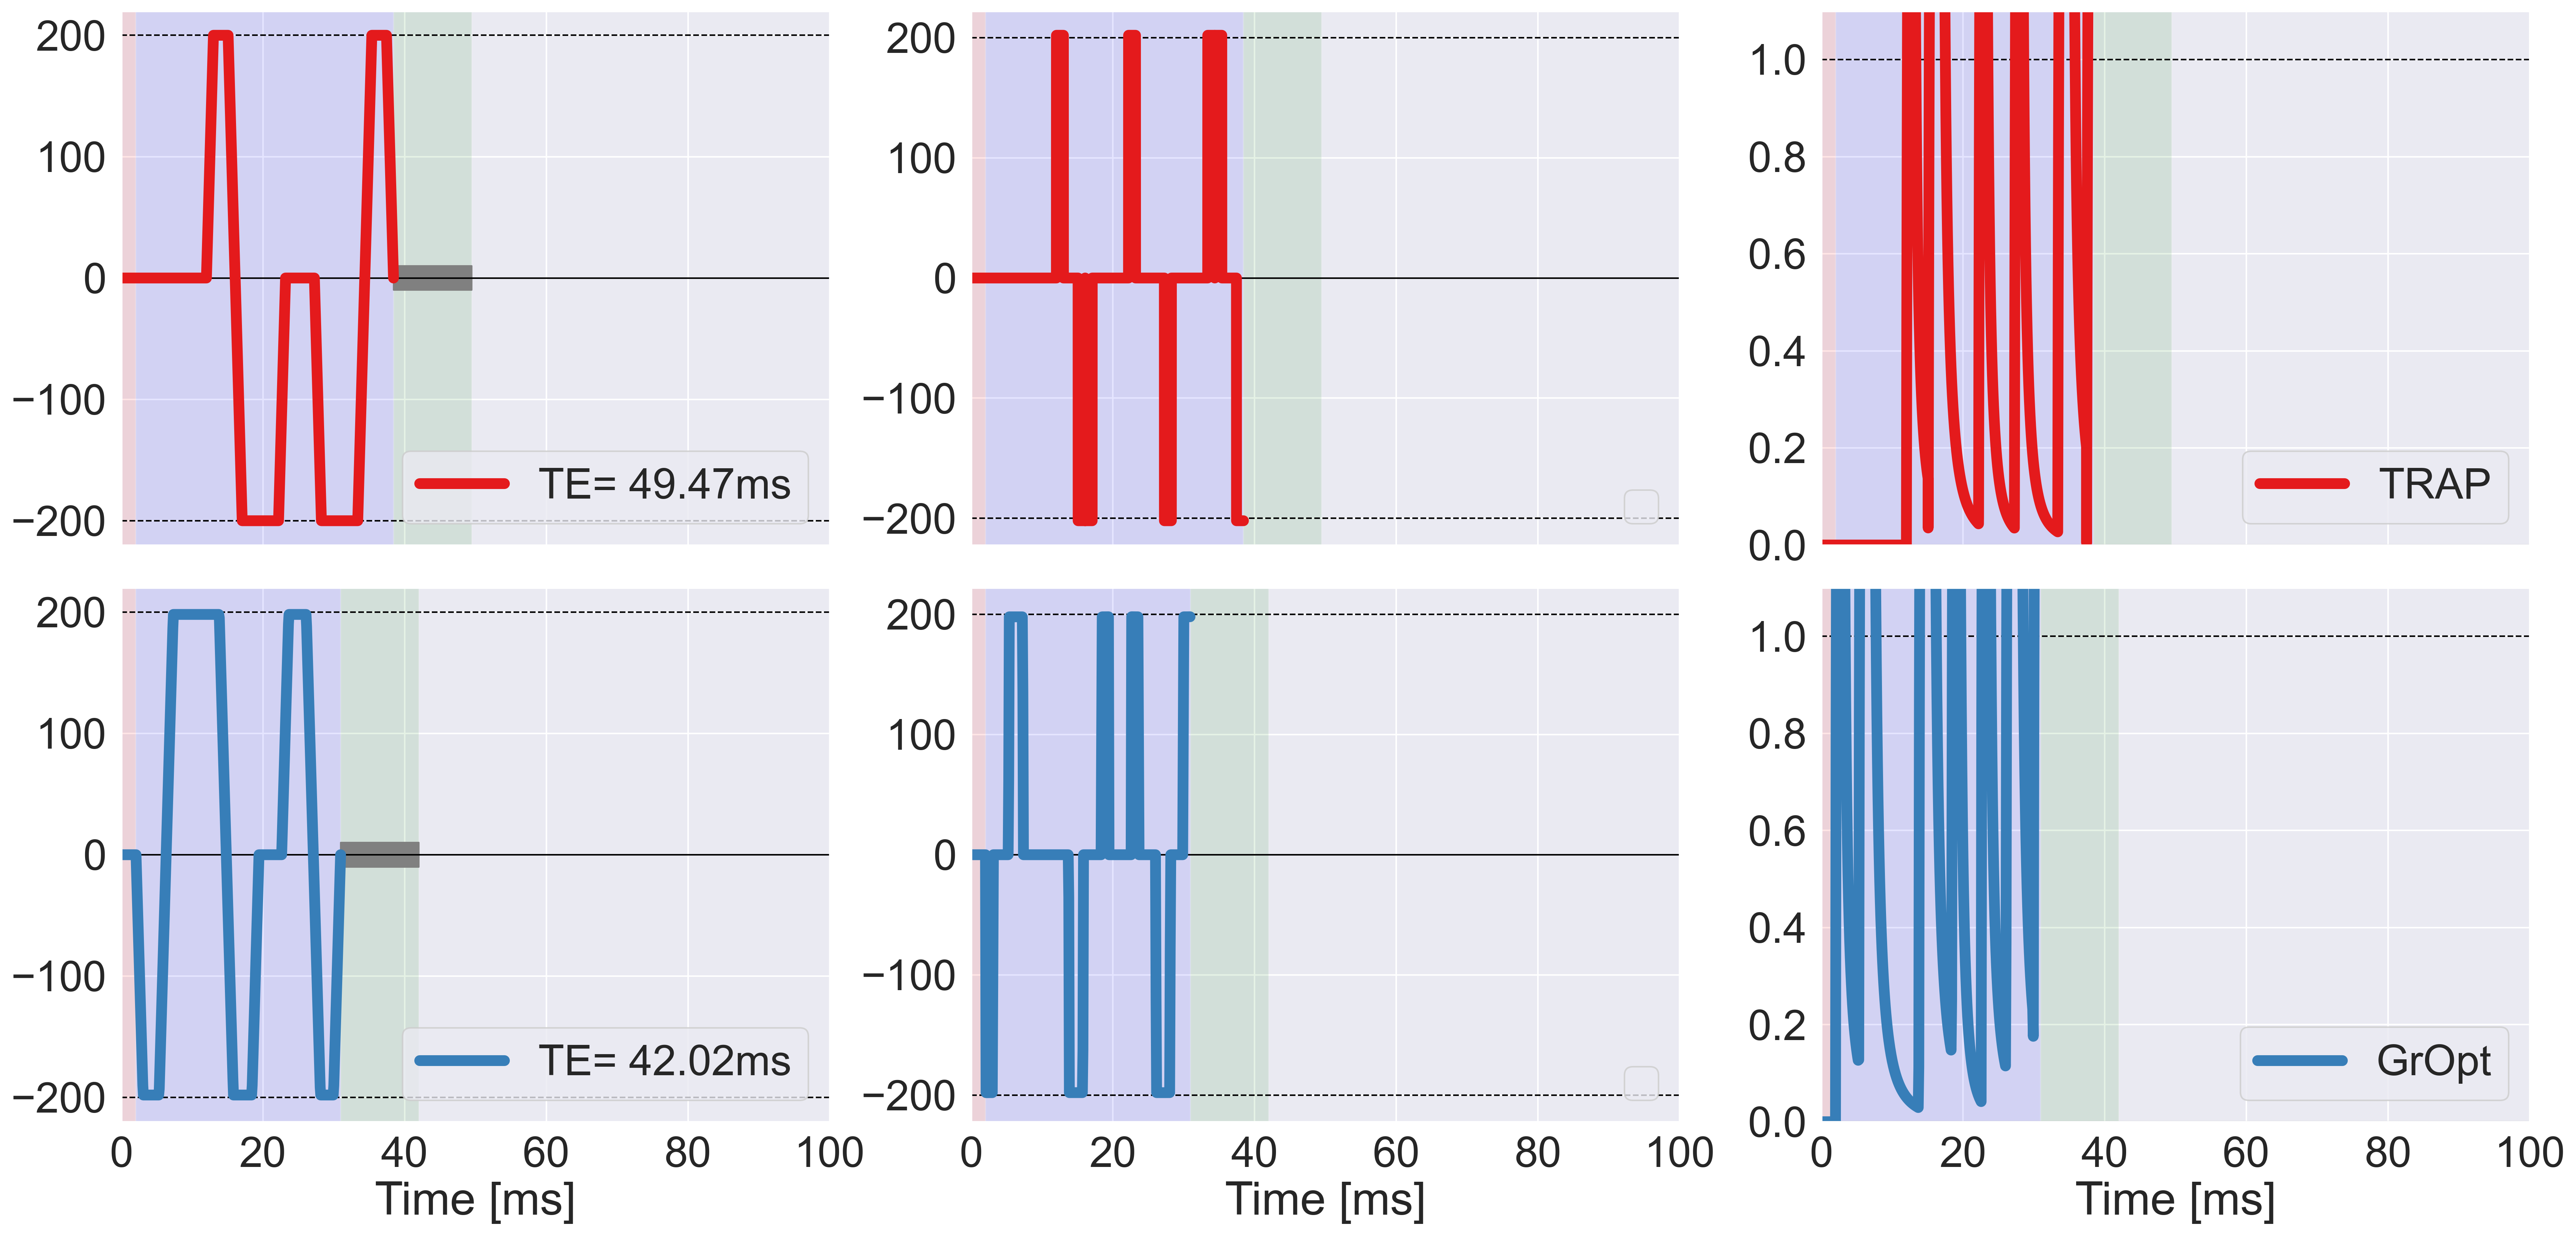

In [10]:
gropt_params['MMT'] = 2

colors = sns.color_palette('Set1')
fig, axes = plt.subplots(nrows=2, ncols=3,  sharex=True,sharey = 'col', figsize=(28, 13), dpi=300)
# Formatting 
for ii in range(2):
    for jj in range(3):
        axes[ii,jj].axhline(0,linewidth = 1,color = 'black',)


axes[1,0].axhline(gropt_params['gmax'], linewidth = 1,color='black',linestyle='--' )
axes[1,0].axhline(-gropt_params['gmax'], linewidth = 1,color='black',linestyle='--' )
axes[0,0].axhline(gropt_params['gmax'], linewidth = 1,color='black',linestyle='--' )
axes[0,0].axhline(-gropt_params['gmax'], linewidth = 1,color='black',linestyle='--' )

axes[1,1].axhline(gropt_params['smax'], linewidth = 1,color='black',linestyle='--' )
axes[1,1].axhline(-gropt_params['smax'], linewidth = 1,color='black',linestyle='--' )
axes[0,1].axhline(gropt_params['smax'], linewidth = 1,color='black',linestyle='--' )
axes[0,1].axhline(-gropt_params['smax'], linewidth = 1,color='black',linestyle='--' )

for jj in range(2):
    axes[jj,2].axhline(1, linewidth = 1,color='black',linestyle='--' )
    axes[jj,2].set_ylim([0,1.1])

#for ii in range(2):
#    axes[ii,0].set_ylabel('Gradient (mT/m)')
#    axes[ii,1].set_ylabel('Slew Rate (T/m/ms)')
#    axes[ii,2].set_ylabel('PNS (% Threshold)')



###########################################
# Plot First Gradient Pairs for the Premier Scanner System
# Plot the Gradients 

time_range = np.linspace(0, (grad_TRAP_m0.shape[0]-1) * input_params['dt'] * 1e3, grad_TRAP_m0 .shape[0])
axes[0,0].plot(time_range, grad_TRAP_m0*1e3,linewidth =7,color = colors[0], label = 'TE= {:.2f}ms'.format(TE_TRAP_m0))
axes[0,1].plot(time_range[:-1], np.diff(grad_TRAP_m0)/input_params['dt'],linewidth =7,color = colors[0])

for idx in range(3):
    axes[0,idx].axvspan(0,input_params['T_90'], facecolor='red', alpha=0.1,zorder = 1)
    axes[0,idx].axvspan(input_params['T_90'],time_range[-1], facecolor='blue', alpha=0.1,zorder = 1)
    axes[0,idx].axvspan(time_range[-1],time_range[-1]+input_params['T_readout'], facecolor='green', alpha=0.1,zorder = 1)
axes[0,0].fill_between([time_range[-1],time_range[-1]+input_params['T_readout']],10,-10, color= 'gray', zorder = 1)
axes[0,0].set_xlim([0,100])

pns= np.abs(get_stim(grad_TRAP_m0[np.newaxis,:], input_params['dt'])) 
axes[0,2].plot(time_range[:-1],pns,linewidth =7,color = colors[0],label = 'TRAP')


time_range = np.linspace(0, (grad_GrOpt_m0.shape[1]-1) * gropt_params['dt'] * 1e3, grad_GrOpt_m0 .shape[1])
axes[1,0].plot(np.squeeze(time_range), np.squeeze(grad_GrOpt_m0)*1e3,linewidth =7,color = colors[1],zorder =2,label = 'TE= {:.2f}ms'.format(TE_GrOpt_m0))
axes[1,1].plot(time_range[:-1], np.diff(np.squeeze(grad_GrOpt_m0))/gropt_params['dt'],linewidth =7,color = colors[1])

for idx in range(3):
    axes[1,idx].axvspan(0,input_params['T_90'], facecolor='red', alpha=0.1,zorder = 1)
    axes[1,idx].axvspan(input_params['T_90'],time_range[-1], facecolor='blue', alpha=0.1,zorder = 1)
    axes[1,idx].axvspan(time_range[-1],time_range[-1]+input_params['T_readout'], facecolor='green', alpha=0.1,zorder = 1)
axes[1,0].fill_between([time_range[-1],time_range[-1]+input_params['T_readout']],10,-10, color= 'gray', zorder = 1)

pns= np.abs(get_stim(grad_GrOpt_m0, gropt_params['dt'])) 
axes[1,2].plot(time_range[:-1],pns,linewidth =7,color = colors[1],label = 'GrOpt')


groptG = np.squeeze((grad_GrOpt_m0))
zero_crossings = np.where(np.diff(np.sign(groptG)))[0]
sums_between_zero_crossings = []
range_zero_crossings =[]

# Calculate the sums between zero crossings
for i in range(len(zero_crossings) - 1):
    start_idx = zero_crossings[i] + 1  # Start one index after the zero crossing
    end_idx = zero_crossings[i + 1]  # Up to the next zero crossing
    sum_values = np.sum(abs(groptG[start_idx:end_idx]))
    sums_between_zero_crossings.append(sum_values)
    range_zero_crossings.append([start_idx,end_idx])

index_closest_to_zero = np.argmin(np.abs(sums_between_zero_crossings))

start_idx = range_zero_crossings[index_closest_to_zero][0]
end_idx = range_zero_crossings[index_closest_to_zero][1]

start = (time_range)[start_idx]
end= (time_range)[end_idx]
midpoint = (start+end)/2
start_180 = midpoint - gropt_params['T_180']/2
x = np.arange(-3, 3, gropt_params['dt'])
# Calculate the truncated sinc function
y = np.sinc(x) 
# Set values outside the range to 0
y[x < -3] = 0
y[x > 3] = 0
x2 = np.linspace(start_180, start_180 + gropt_params['T_180'], int(gropt_params['T_180'] / gropt_params['dt']) + 1)

min_length = min(len(x2), len(y))
x2 = x2[:min_length]
y = y[:min_length]
#axes[1,0].plot(x2,y*80*0.3,linewidth =2, color='black')



#############################################################################################################

for ii in range(2):
    for jj in range(2):

        axes[ii,jj].legend(loc='lower right')


axes[0,2].legend(loc='lower right')
axes[1,2].legend(loc='lower right')


for ii in range(3):
    axes[-1,ii].set_xlabel('Time [ms]')


plt.subplots_adjust(wspace=0.2, hspace=0.08)  
plt.show()

fig.savefig('M2_200.svg')


In [11]:
np.max(grad_TRAP_m0)

0.2

# Prototype M3

In [12]:
bval = [1000]
T_readout = [10]
tol = 0.01

gropt_track = np.zeros((len(bval),len(T_readout)))
trap_track = np.zeros((len(bval),len(T_readout)))

for bb in range(len(bval)):
    for tt in range(len(T_readout)):

        input_params ={'mode': 'diff_bval', 
            'T_90': 3, 
            'T_180': 5, 
            'gmax': 200, 
            'smax': 200, 
            'dt': 8e-05, 
            'T_readout': T_readout[tt],
            'b': bval[bb], 
            'MMT': 3, 
            'pns_thresh': 0.9}

        pns = 2
        iter = 0

        G_gropt, TE =  get_min_TE(input_params,verbose = True, bval =input_params['b'])
        gropt_b = get_bval(G_gropt, input_params)
        print('GrOpt b-val ={:.2f}'.format(gropt_b))

        gropt_track[bb,tt] = TE
        np.savetxt('results_gropt_mmt2.csv', gropt_track, delimiter=',',  comments='', fmt='%.6f')


        input_params['b'] = gropt_b

        while np.max(pns) > input_params['pns_thresh']:
            g,t,TE,b,zeta,flat, = asymmM3(input_params, tol)
            #plt.plot(g)
            #plt.ylim([-.200,.200])
            pns = np.abs(get_stim(g[np.newaxis,:], input_params['dt']))

            input_params['smax']-=5
            
            if len(g) == 1:
                input_params['gmax']-=5
                input_params['smax']=200
                pns = 2

        print('TRAP b-val ={:.2f}, TRAP TE = {:.2f}'.format(b,TE))
        trap_track[bb,tt] = TE
        np.savetxt('results_trap_mmt2.csv', trap_track, delimiter=',',  comments='',fmt='%.6f')


grad_TRAP_m2 = G
grad_GrOpt_m2 = G_gropt

TE_TRAP_m2 = echoT
TE_GrOpt_m2 = gropt_params['TE']

Testing TE = 114.000 71.000 49.500 60.250 54.875 57.562 58.906 59.578 59.914 59.746 59.830 59.872 59.893 59.883 Final TE = 59.883 ms
GrOpt b-val =1013.44


NameError: name 'asymmM3' is not defined

In [ ]:

def asymmM3(params, tol):
    # Define waveform parameters
    T_90 = params['T_90'] * 1e-3
    T_180 = params['T_180'] * 1e-3
    dt = params['dt']
    Gmax = params['gmax'] / 1000
    Smax = params['smax'] / 1000
    GAM = 2 * np.pi * 42.58e3
    zeta = (Gmax / Smax) * 1e-3
    target_bval = params['b']
    b = 0
    flat = 0e-3
    motion_comp = params['MMT']
    prev_t = np.array([0])
    prev_g = np.array([0])

    while flat <= 100000e-3 :
        if 2*zeta+ flat < T_180:
            diff = T_180 - 2*zeta
            flat = flat+diff
        
        if motion_comp == 3: 
            
            t = []
            g = []
            gap = params['T_readout'] * 1e-3 - T_90/2 
            # Add in the time spent to slew up 
            gap_p_180=  2*zeta +flat 
            
            flat_time = flat*2 + zeta 

            flat_time2 =  gap_p_180 - flat - zeta

            intervals = [T_90, gap, zeta, flat, zeta, zeta,flat,flat, zeta, zeta,flat,zeta, \
                         T_180, zeta,flat,zeta,zeta, flat,flat, zeta,zeta,flat,zeta]

            time = [
                np.linspace(0, T_90 + gap, int((T_90 + gap) / dt)),
                np.linspace(T_90 + gap, T_90 + gap + zeta, int(zeta / dt)),
                np.linspace(T_90 + gap + zeta, T_90 + gap + zeta + flat, int(flat / dt)),
                np.linspace(T_90 + gap + zeta + flat, T_90 + gap + zeta + flat + zeta, int(zeta / dt)),
                np.linspace(T_90 + gap + zeta + flat + zeta, T_90 + gap + zeta + flat + zeta + zeta, int(zeta / dt)),
                np.linspace(T_90 + gap + zeta + flat + zeta + zeta, T_90 + gap + zeta + flat + zeta + zeta + flat_time, int(flat_time / dt)),
                np.linspace(T_90 + gap + zeta + flat + zeta + zeta + flat_time, T_90 + gap + zeta + flat + zeta + zeta + flat_time + zeta, int(zeta / dt)),
                np.linspace(T_90 + gap + zeta + flat + zeta + zeta + flat_time + zeta, T_90 + gap + zeta + flat + zeta + zeta + flat_time + zeta + zeta, int(zeta / dt)),
                np.linspace(T_90 + gap + zeta + flat + zeta + zeta + flat_time + zeta + zeta, T_90 + gap + zeta + flat + zeta + zeta + flat_time + zeta + zeta + flat_time2, int(flat_time2 / dt)),
                np.linspace(T_90 + gap + zeta + flat + zeta + zeta + flat_time + zeta + zeta + flat_time2, T_90 + gap + zeta + flat + zeta + zeta + flat_time + zeta + zeta + flat_time2 + zeta, int(zeta / dt)),
                np.linspace(T_90 + gap + zeta + flat + zeta + zeta + flat_time + zeta + zeta + flat_time2 + zeta, T_90 + gap + zeta + flat + zeta + zeta + flat_time + zeta + zeta + flat_time2 + zeta + gap_p_180, int(gap_p_180 / dt)),
                np.linspace(T_90 + gap + zeta + flat + zeta + zeta + flat_time + zeta + zeta + flat_time2 + zeta + gap_p_180, T_90 + gap + zeta + flat + zeta + zeta + flat_time + zeta + zeta + flat_time2 + zeta + gap_p_180 + zeta, int(zeta / dt)),
                np.linspace(T_90 + gap + zeta + flat + zeta + zeta + flat_time + zeta + zeta + flat_time2 + zeta + gap_p_180 + zeta, T_90 + gap + zeta + flat + zeta + zeta + flat_time + zeta + zeta + flat_time2 + zeta + gap_p_180 + zeta + flat_time2, int(flat_time2 / dt)),
                np.linspace(T_90 + gap + zeta + flat + zeta + zeta + flat_time + zeta + zeta + flat_time2 + zeta + gap_p_180 + zeta + flat_time2, T_90 + gap + zeta + flat + zeta + zeta + flat_time + zeta + zeta + flat_time2 + zeta + gap_p_180 + zeta + flat_time2 + zeta, int(zeta / dt)),
                np.linspace(T_90 + gap + zeta + flat + zeta + zeta + flat_time + zeta + zeta + flat_time2 + zeta + gap_p_180 + zeta + flat_time2 + zeta, T_90 + gap + zeta + flat + zeta + zeta + flat_time + zeta + zeta + flat_time2 + zeta + gap_p_180 + zeta + flat_time2 + zeta + zeta, int(zeta / dt)),
                np.linspace(T_90 + gap + zeta + flat + zeta + zeta + flat_time + zeta + zeta + flat_time2 + zeta + gap_p_180 + zeta + flat_time2 + zeta + zeta, T_90 + gap + zeta + flat + zeta + zeta + flat_time + zeta + zeta + flat_time2 + zeta + gap_p_180 + zeta + flat_time2 + zeta + zeta + flat_time, int(flat_time / dt)),
                np.linspace(T_90 + gap + zeta + flat + zeta + zeta + flat_time + zeta + zeta + flat_time2 + zeta + gap_p_180 + zeta + flat_time2 + zeta + zeta + flat_time, T_90 + gap + zeta + flat + zeta + zeta + flat_time + zeta + zeta + flat_time2 + zeta + gap_p_180 + zeta + flat_time2 + zeta + zeta + flat_time + zeta, int(zeta / dt)),
                np.linspace(T_90 + gap + zeta + flat + zeta + zeta + flat_time + zeta + zeta + flat_time2 + zeta + gap_p_180 + zeta + flat_time2 + zeta + zeta + flat_time + zeta, T_90 + gap + zeta + flat + zeta + zeta + flat_time + zeta + zeta + flat_time2 + zeta + gap_p_180 + zeta + flat_time2 + zeta + zeta + flat_time + zeta + zeta, int(zeta / dt)),
                np.linspace(T_90 + gap + zeta + flat + zeta + zeta + flat_time + zeta + zeta + flat_time2 + zeta + gap_p_180 + zeta + flat_time2 + zeta + zeta + flat_time + zeta + zeta, T_90 + gap + zeta + flat + zeta + zeta + flat_time + zeta + zeta + flat_time2 + zeta + gap_p_180 + zeta + flat_time2 + zeta + zeta + flat_time + zeta + zeta + flat, int(flat / dt)),
                np.linspace(T_90 + gap + zeta + flat + zeta + zeta + flat_time + zeta + zeta + flat_time2 + zeta + gap_p_180 + zeta + flat_time2 + zeta + zeta + flat_time + zeta + zeta + flat, T_90 + gap + zeta + flat + zeta + zeta + flat_time + zeta + zeta + flat_time2 + zeta + gap_p_180 + zeta + flat_time2 + zeta + zeta + flat_time + zeta + zeta + flat + zeta, int(zeta / dt)),
     

                
            ]



            gradient = [
                np.zeros_like(time[0]),

                np.linspace(0,Gmax,num = len(time[1])),
                Gmax*np.ones_like(time[2]),
                np.linspace(Gmax,0,num = len(time[3])),

                np.linspace(0,-Gmax,num = len(time[4])),
                -Gmax*np.ones_like(time[5]),
                np.linspace(-Gmax,0,num = len(time[6])),

                np.linspace(0,Gmax,num = len(time[7])),
                Gmax*np.ones_like(time[8]),
                np.linspace(Gmax,0,num = len(time[9])),

                np.zeros_like(time[10]),

                np.linspace(0,Gmax,num = len(time[11])),
                Gmax*np.ones_like(time[12]),
                np.linspace(Gmax,0,num = len(time[13])),

                np.linspace(0,-Gmax,num = len(time[14])),
                -Gmax*np.ones_like(time[15]),
                np.linspace(-Gmax,0,num = len(time[16])),
                
                np.linspace(0,Gmax,num = len(time[17])),
                Gmax*np.ones_like(time[18]),
                np.linspace(Gmax,0,num = len(time[19])),
                ]


            

            t = np.concatenate(time,axis = 0)
            g = np.concatenate(gradient,axis = 0)

        else: 
            print('Invalid Motion Compensation Parameter')
            break

        TE = t[-1] * 1e3 + params['T_readout']
        params['TE'] = TE

        
        b = get_bval(g[np.newaxis,:],params)
        if (np.abs(b - target_bval) <= target_bval*tol): # Stop if the calculated b-value is within 1% of the target
            break
        elif b > (target_bval + target_bval*tol) :
            print('\tNot within tolerance but bval exceeded: bval = {:.2f},flat = {:.2f},te={:.2f}'.format(b,flat,TE))
            
            prev_bval = get_bval(prev_g[np.newaxis,:-1],params)
            print(prev_bval)
            if prev_bval - target_bval < b- target_bval:
                g=prev_g
                t=prev_t
                break


                

            
            

            
        else:
            flat += dt
        prev_t = t
        prev_g = g
        flat += dt

        
        
    return g,t,TE,b,zeta,flat,


In [ ]:
nput_params ={'mode': 'diff_bval', 
            'T_90': 3, 
            'T_180': 5, 
            'gmax': 200, 
            'smax': 200, 
            'dt': 8e-05, 
            'T_readout': T_readout[tt],
            'b': bval[bb], 
            'MMT': 3, 
            'pns_thresh': 1000}

pns = 10000
iter = 0

while np.max(pns) > input_params['pns_thresh']:
    g,t,TE,b,zeta,flat, = asymmM3(input_params, tol)
    #plt.plot(g)
    #plt.ylim([-.200,.200])
    pns = np.abs(get_stim(g[np.newaxis,:], input_params['dt']))

    input_params['smax']-=5
    
    if len(g) == 1:
        input_params['gmax']-=5
        input_params['smax']=200
        pns = 2

print('TRAP b-val ={:.2f}, TRAP TE = {:.2f}'.format(b,TE))
grad_trap = g


	Not within tolerance but bval exceeded: bval = 1068.53,flat = 0.00,te=101.47
1001.3366802171802
TRAP b-val =1068.53, TRAP TE = 101.47


1.2082419432758006e-16   -0.044842291939365765   -0.053702939811747244   -0.11732932177024795   -0.21563834010259433   

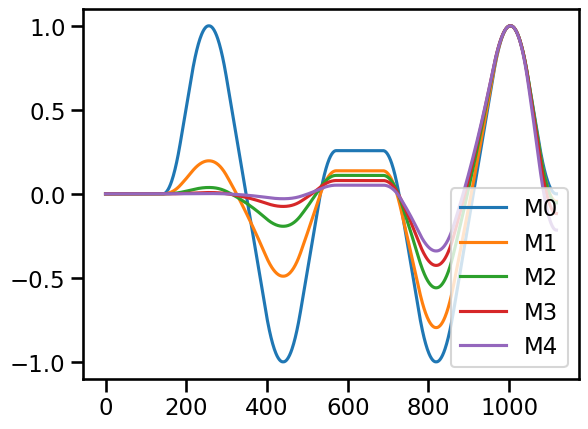

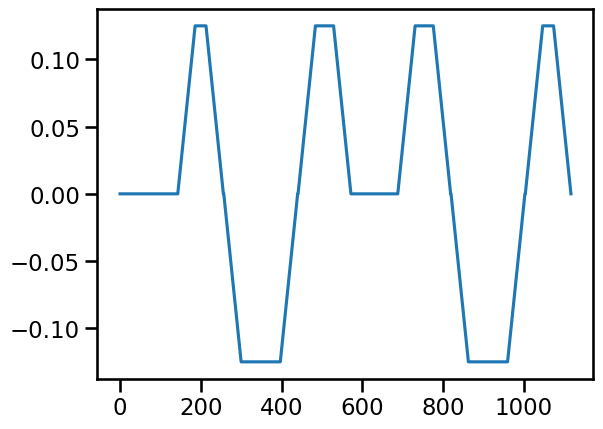

In [ ]:

def get_moments2(G, T_readout, dt):
    G=np.squeeze(G)
    TE = G.size*dt*1e3 + T_readout
    tINV = int(np.floor(TE/dt/1.0e3/2.0))
    GAMMA   = 42.58e3; 
    INV = np.ones(G.size)
    INV[tINV:] = -1
    Nm = 5
    tvec = np.arange(G.size)*dt
    tMat = np.zeros((Nm, G.size))
    for mm in range(Nm):
        tMat[mm] = tvec**mm

    moments = np.abs(GAMMA*dt*tMat@(G*INV))
    mm = GAMMA*dt*tMat * (G*INV)[np.newaxis,:]

    mmt = np.cumsum(mm[0])
    m0=mmt/np.abs(mmt).max()
    mmt = np.cumsum(mm[1])
    m1=mmt/np.abs(mmt).max()
    mmt = np.cumsum(mm[2])
    m2=mmt/np.abs(mmt).max()
    mmt = np.cumsum(mm[3])
    m3=mmt/np.abs(mmt).max()
    mmt = np.cumsum(mm[4])
    m4=mmt/np.abs(mmt).max()

    return m0,m1,m2,m3,m4


moments = get_moments2(grad_trap, input_params['T_readout'], input_params['dt'])
sns.set_context("talk")
count = 0
for mm in moments:
    plt.plot(mm,label = 'M{}'.format(count) )
    count+=1
    print(mm[-1],end = '   ')
plt.legend()

plt.show()
plt.plot(grad_trap)